# Human vs AI Text Classification

## Data from Kaggle

- [Kaggle Competition](https://www.kaggle.com/competitions/human-vs-ai-text-classification-feb2024/data)
- [Kaggle Dataset](https://www.kaggle.com/datasets/shanegerami/ai-vs-human-text/data)

The data is of the form:

| text | generated |
|------|--------|
| text | 0 |
| text | 1 |
---

where `generated` is a 0 for human or 1 for AI.

The goal of this notebook is to classify whether a given text is written by a human or AI. I will be using a combination of traditional NLP techniques and more modern approaches using transformers and transfer learning.

## Imports

In [1]:
# Standard libraries
import numpy as np
import pandas as pd
import re
import string

# NLTK
import nltk
from nltk.corpus import words, stopwords
from nltk.tokenize import word_tokenize, sent_tokenize

# Download the punkt tokenizer if not already downloaded
nltk.download('punkt', quiet=True)
# Scikit-learn
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report
from sklearn.utils.class_weight import compute_class_weight

# Scikit-learn models
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB


import matplotlib.pyplot as plt
# NLTK Data
try:
    nltk.data.find('corpora/words')
except LookupError:
    nltk.download('words')
    
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')
    
try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')

## Helper Functions

In [2]:
# Create a set of English words
english_words = set(words.words())

# Function to count misspelled words
def count_misspelled_words(text):
    word_list = nltk.word_tokenize(text.lower())
    misspelled = sum(1 for word in word_list if word.isalpha() and word not in english_words)
    return misspelled


def clean_text(text):
    # Convert to lowercase
    text = text.lower()
    
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    
    # Remove special characters and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # Tokenize the text
    tokens = word_tokenize(text)
    
    # Remove stopwords
    # stop_words = set(stopwords.words('english'))
    # tokens = [word for word in tokens if word not in stop_words]
    
    # Join the tokens back into a string
    cleaned_text = ' '.join(tokens)
    
    return cleaned_text


# Function to split text into sentences and create new rows
def split_text_to_sentences(text, label):
    sentences = sent_tokenize(text)
    return pd.DataFrame({'text': sentences, 'generated': [label] * len(sentences)})

## Code

In [6]:
# Load the data
df1 = pd.read_csv('data/train.csv')
df2 = pd.read_csv('data/AI_Human.csv')
test_df = pd.read_csv('data/test.csv')

df = pd.concat([df1, df2])

# Delete the original dataframes to save memory
del df1, df2

# Drop duplicates
df = df.drop_duplicates()
# train.csv seems to be already contained in Ai_Human.csv
# Save the dataframe to a new csv file
# labels are imbalanced 305797 human and 1181438 AI
df.to_csv('data/no_duplicates.csv', index=False)

# Apply the function to each row and concatenate the results
df_sentences = df.apply(lambda row: split_text_to_sentences(row['text'], row['generated']), axis=1)
df_sentences = pd.concat(df_sentences.tolist(), ignore_index=True)

# Replace the original dataframe with the sentence-level dataframe
df = df_sentences

print("Shape of the dataframe after splitting into sentences:", df.shape)
print("\nFirst few rows of the new dataframe:")
print(df.head())

# Update the train-validation split with the new sentence-level data
train_texts, val_texts, train_labels, val_labels = train_test_split(df['text'], df['generated'], test_size=0.2, random_state=42, stratify=df['generated'])

# Clean the text data at sentence level
train_texts_cleaned = train_texts.apply(clean_text)
val_texts_cleaned = val_texts.apply(clean_text)



Shape of the dataframe after splitting into sentences: (9860730, 2)

First few rows of the new dataframe:
                                                text  generated
0                                              Cars.        0.0
1  Cars have been around since they became famous...        0.0
2  Cars have played a major role in our every day...        0.0
3  But now, people are starting to question if li...        0.0
4  To me, limiting the use of cars might be a goo...        0.0


In [7]:
# Combine TF-IDF features with extra features
tfidf = TfidfVectorizer(max_features=5000)
train_features = tfidf.fit_transform(train_texts)
val_features= tfidf.transform(val_texts)

print("Shape of training features:", train_features.shape)
print("Shape of validation features:", val_features.shape)

Shape of training features: (7888584, 5000)
Shape of validation features: (1972146, 5000)


In [8]:
# Calculate class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_labels), y=train_labels)
class_weight_dict = dict(zip(np.unique(train_labels), class_weights))
print("Class weights:", class_weight_dict)

# Define the models
models = {
    'Logistic Regression': LogisticRegression(),
    'Naive Bayes': MultinomialNB(),
    'Weighted Logistic Regression': LogisticRegression(class_weight=class_weight_dict),
}

# Evaluate each model using cross-validation
for name, model in models.items():
    scores = cross_val_score(model, train_features, train_labels, cv=5)
    print(f"{name}: Mean accuracy: {scores.mean():.4f} (+/- {scores.std() * 2:.4f})")


Class weights: {np.float64(0.0): np.float64(0.757991908305143), np.float64(1.0): np.float64(1.4690226396725186)}


/Users/rhysjervis/Documents/GitHub/AI vs Human Text Classification Logistic Regression Model Analysis/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression: Mean accuracy: 0.8847 (+/- 0.0008)
Naive Bayes: Mean accuracy: 0.8538 (+/- 0.0006)
Weighted Logistic Regression: Mean accuracy: 0.8739 (+/- 0.0008)


## Save and evaluate models

In [9]:
import joblib
import os

# Create a directory to store the models if it doesn't exist
if not os.path.exists('saved_models'):
    os.makedirs('saved_models')
    
# Train and save each model
for name, model in models.items():
    print(f"Training {name}...")
    model.fit(train_features, train_labels)
    
    # Save the model
    joblib.dump(model, f'saved_models/{name.replace(" ", "_").lower()}.joblib')
    print(f"{name} saved.")

    # Evaluate the model
    val_pred = model.predict(val_features)
    accuracy = accuracy_score(val_labels, val_pred)
    print(f"{name} Accuracy: {accuracy:.4f}")
    print(classification_report(val_labels, val_pred))
    print("\n")

Training Logistic Regression...
Logistic Regression saved.
Logistic Regression Accuracy: 0.8850
              precision    recall  f1-score   support

         0.0       0.90      0.93      0.91   1300902
         1.0       0.86      0.79      0.82    671244

    accuracy                           0.88   1972146
   macro avg       0.88      0.86      0.87   1972146
weighted avg       0.88      0.88      0.88   1972146



Training Naive Bayes...
Naive Bayes saved.
Naive Bayes Accuracy: 0.8537
              precision    recall  f1-score   support

         0.0       0.85      0.95      0.90   1300902
         1.0       0.87      0.67      0.76    671244

    accuracy                           0.85   1972146
   macro avg       0.86      0.81      0.83   1972146
weighted avg       0.86      0.85      0.85   1972146



Training Weighted Logistic Regression...
Weighted Logistic Regression saved.
Weighted Logistic Regression Accuracy: 0.8744
              precision    recall  f1-score   suppo

### Load the saved models and plot the feature importance

In [10]:
# Load the saved models
unweighted_lr = joblib.load('saved_models/logistic_regression.joblib')
unweighted_nb = joblib.load('saved_models/naive_bayes.joblib')
weighted_lr = joblib.load('saved_models/weighted_logistic_regression.joblib')

Unweighted Logistic Regression Feature Importance:


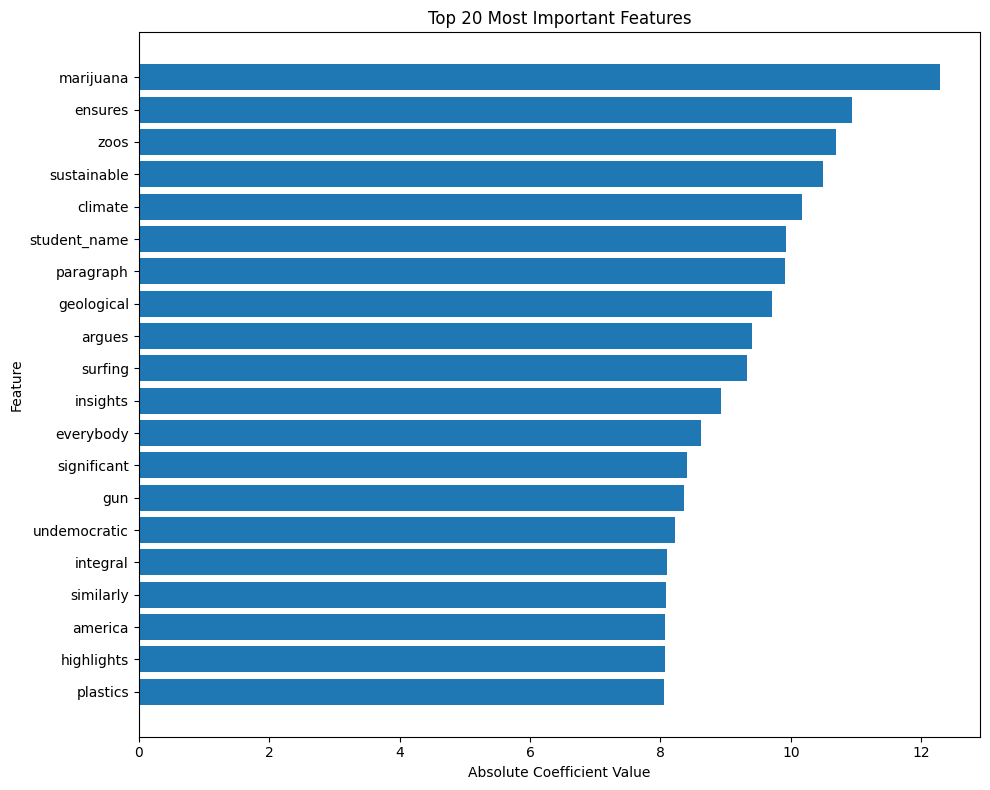


Weighted Logistic Regression Feature Importance:


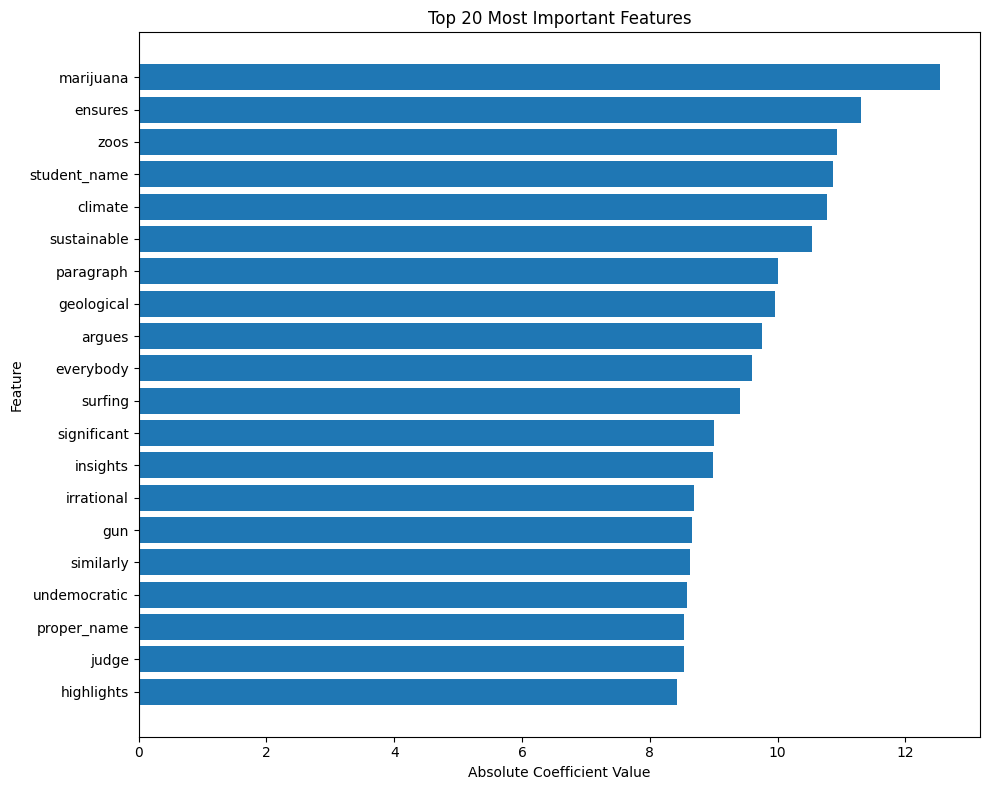


Unweighted Logistic Regression:
Top 10 most important features:
marijuana: 12.2864
ensures: 10.9340
zoos: 10.6893
sustainable: 10.4931
climate: 10.1663
student_name: -9.9336
paragraph: -9.9043
geological: 9.7099
argues: 9.4034
surfing: 9.3249

Weighted Logistic Regression:
Top 10 most important features:
marijuana: 12.5422
ensures: 11.3111
zoos: 10.9266
student_name: -10.8736
climate: 10.7764
sustainable: 10.5412
paragraph: -10.0105
geological: 9.9602
argues: 9.7578
everybody: -9.5951


In [11]:
def plot_feature_importance(model, feature_names, top_n=20):
    # Get feature coefficients
    coefficients = model.coef_[0]
    
    # Create a dataframe of features and their coefficients
    feature_importance = pd.DataFrame({'feature': feature_names, 'importance': abs(coefficients)})
    
    # Sort by absolute importance and get top n
    feature_importance = feature_importance.sort_values('importance', ascending=False).head(top_n)
    
    # Plot
    plt.figure(figsize=(10, 8))
    plt.barh(feature_importance['feature'], feature_importance['importance'])
    plt.title(f'Top {top_n} Most Important Features')
    plt.xlabel('Absolute Coefficient Value')
    plt.ylabel('Feature')
    plt.gca().invert_yaxis()  # Invert y-axis to show most important at the top
    plt.tight_layout()
    plt.show()
    
# Get feature names
tfidf_feature_names = tfidf.get_feature_names_out()


# Plot feature importance for unweighted Logistic Regression
print("Unweighted Logistic Regression Feature Importance:")
plot_feature_importance(unweighted_lr, tfidf_feature_names)

# Plot feature importance for weighted Logistic Regression
print("\nWeighted Logistic Regression Feature Importance:")
plot_feature_importance(weighted_lr, tfidf_feature_names)

# Print top 10 most important features and their coefficients
def print_top_features(model, feature_names, top_n=10):
    coefficients = model.coef_[0]
    feature_importance = pd.DataFrame({'feature': feature_names, 'coefficient': coefficients})
    feature_importance['abs_coefficient'] = abs(feature_importance['coefficient'])
    top_features = feature_importance.sort_values('abs_coefficient', ascending=False).head(top_n)
    
    print(f"Top {top_n} most important features:")
    for _, row in top_features.iterrows():
        print(f"{row['feature']}: {row['coefficient']:.4f}")

print("\nUnweighted Logistic Regression:")
print_top_features(unweighted_lr, tfidf_feature_names)

print("\nWeighted Logistic Regression:")
print_top_features(weighted_lr, tfidf_feature_names)

### Summary of Feature Importances in Logistic Model for Predicting Human vs. AI-Generated Text

1. **Positive vs. Negative Coefficients:**
   - **Positive Coefficients** are associated with features that increase the likelihood of the text being AI-generated. These words or phrases tend to be more formal, structured, and indicative of AI's approach to constructing text.
   - **Negative Coefficients** are linked to features that increase the likelihood of the text being human-written. These words or phrases reflect a more casual, natural style, often involving causal explanations and contrasting ideas, characteristic of human writing.

2. **Magnitude of Coefficients:**
   - The magnitude (absolute value) of the coefficients indicates the significance of each feature in the model's predictions. Features with larger magnitudes have a stronger impact on whether the model classifies text as AI-generated or human-written.

3. **Insights:**
   - **AI-Generated Text** tends to exhibit a formal, structured style with explicit transitions and conclusions. This language is often more formulaic, emphasizing clarity and organization.
   - **Human-Written Text** displays a more casual and varied style, often using causal explanations and contrasting ideas. This reflects human creativity and a flexible approach to writing.